<a href="https://colab.research.google.com/github/CD-GRUPO3/TA047R-1C2025-GRUPO03/blob/main/TA047R_TP1_GRUPO03_ENTREGA_EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Grupo 3 - Ejercicio 1: *Análisis exploratorio de datos*
**Objetivo:** realizar un análisis completo del conjunto de datos, aplicar técnicas de exploración y de preprocesamiento para poder responder algunas preguntas que se planteen sobre los datos.

**Conjunto de datos:** [uso de Taxis Yellow Cab en USA](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), particularmente los meses **Julio**, **Agosto** y **Septiembre**.

**Integrantes:**
- ARIAS, Rafaela Pilar. 112272. rparias@fi.uba.ar.
- BARCALA ROCA, Ramiro. 112478. rbarcala@fi.uba.ar.
- LEMA, Mora. 111831. molema@fi.uba.ar.
- IENCO, Lara Eliana. 111921. lienco@fi.uba.ar.

___

####Bibliografía:
Julca, J. E. (2025, febrero 22). Tipos de variables estadísticas: Cuantitativas y Cualitativas. Escuela de Investigación. Recuperado de: [Link](https://escueladeinvestigacion.com/2025/02/22/tipos-de-variables-estadisticas-cuantitativas-y-cualitativas/).

Sin Autor, (2022, junio 7). ¿Qué es una variable discreta? (ejemplos). Probabilidad y Estadística. [Link](https://www.probabilidadyestadistica.net/variable-discreta/).

Colores HTML: https://htmlcolorcodes.com/es/

NYC coso de congestion_surcharge: https://www.nyc.gov/site/tlc/about/congestion-surcharge.page
https://www.tax.ny.gov/language/espanol/bus/cs/csidx.htm


#####Inicialización del entorno


In [1]:
#Importar las bibliotecas
import matplotlib.pyplot as plt   #Generación de gráficos
import matplotlib.ticker as ticker
import sklearn as sk
import scipy.stats as st
import scipy.linalg as la

import numpy as np                #Operaciones matemáticas y estadísticas
import seaborn as sns             #Generación de gráficos
import pandas as pd               #Manipulación y análisis de datos
import pyarrow.parquet as pq      #Trabajar con archivos .parquet
import plotly.express as px #lo agrego de nuevo -> LARA

from IPython.display import display  #Para mejor visualización en notebooks
#import plotly.graph_objects as go
from plotly.subplots import make_subplots #Para combinar varios gráficos en una sola figura
from tabulate import tabulate

#Configurar Pandas para que no use notación científica (CUALQUIER COSA ELIMINAR!!)
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
#Cargar los datos al Notebook

#Datasets
!gdown 1iju9XQghLYI4-XcDt1TVDE1O9ZwRyFVg
!gdown 1MukhnrymZ35FVsahXUs5I0cAeGJMoXgG
!gdown 1hEhbxXEC7Dc4iG0fKk2k1n8KM6emWxSg

#CSV de estaciones
!gdown 121-MQOXDQI1uTDXgiDETE4VSId1qnYSB

Downloading...
From: https://drive.google.com/uc?id=1iju9XQghLYI4-XcDt1TVDE1O9ZwRyFVg
To: /content/yellow_tripdata_2024-07.parquet
100% 52.3M/52.3M [00:00<00:00, 210MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MukhnrymZ35FVsahXUs5I0cAeGJMoXgG
To: /content/yellow_tripdata_2024-08.parquet
100% 51.1M/51.1M [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hEhbxXEC7Dc4iG0fKk2k1n8KM6emWxSg
To: /content/yellow_tripdata_2024-09.parquet
100% 61.2M/61.2M [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=121-MQOXDQI1uTDXgiDETE4VSId1qnYSB
To: /content/taxi_zone_lookup.csv
100% 12.3k/12.3k [00:00<00:00, 17.1MB/s]


In [3]:
#Obtener cada DataFrame para utilizar Pandas
trips1 = pq.read_table('/content/yellow_tripdata_2024-07.parquet')
dataJulio = trips1.to_pandas()

trips2 = pq.read_table('/content/yellow_tripdata_2024-08.parquet')
dataAgosto = trips2.to_pandas()

trips3 = pq.read_table('/content/yellow_tripdata_2024-09.parquet')
dataSeptiembre = trips3.to_pandas()


stations= pd.read_csv('/content/taxi_zone_lookup.csv')

#Unir los tres Dataframes (uno por mes)
data = pd.concat([dataJulio,dataAgosto,dataSeptiembre],axis=0, ignore_index=True)

#1. Análisis exploratorio y preprocesamiento de datos
---
##a) Exploración inicial
Se realiza un un acercamiento inicial general del dataset observando sus distintas características principales



In [4]:
#Observamos la cantidad de registros inicial del dataset y la cantidad de columnas
shape = data.shape
print("Filas: %d\nColumnas: %d" % (shape[0], shape[1]))


Filas: 9689116
Columnas: 19


In [5]:
#Visualizamos las distintas columnas y su tipo de dato
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9689116 entries, 0 to 9689115
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [6]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-07-01 00:34:56,2024-07-01 00:46:49,1.000000,3.200000,1.000000,N,140,79,1,15.600000,3.500000,0.500000,3.500000,0.000000,1.000000,24.100000,2.500000,0.000000
1,2,2024-06-30 23:48:58,2024-07-01 00:28:04,1.000000,19.480000,2.000000,N,132,113,2,70.000000,0.000000,0.500000,0.000000,0.000000,1.000000,75.750000,2.500000,1.750000
2,2,2024-07-01 00:23:18,2024-07-01 00:29:51,1.000000,1.180000,1.000000,N,237,145,1,8.600000,1.000000,0.500000,2.720000,0.000000,1.000000,16.320000,2.500000,0.000000
3,1,2024-07-01 00:10:33,2024-07-01 00:27:31,0.000000,9.100000,1.000000,N,138,164,1,36.600000,10.250000,0.500000,12.050000,0.000000,1.000000,60.400000,2.500000,1.750000
4,1,2024-07-01 00:07:55,2024-07-01 00:34:34,1.000000,17.700000,2.000000,N,132,263,1,70.000000,1.750000,0.500000,10.000000,6.940000,1.000000,90.190000,0.000000,1.750000


###**Análisis de las variables**
Podemos analizar las variables clasificándolas como:

- **Cuantitativas (numéricas):** continuas y discretas.

- **Cualitativas (categóricas):** nominales y ordinales.

A continuacion describimos los atributos del dataframe según qué tipo de variable sea y su descripción traducida de [data dictionary trip records yellow](https://drive.google.com/file/d/1z_p143jjTUd9OfhkhvhA4uR5R80vwzbF/view?usp=sharing).

**CUANTITATIVAS:**
- **tpep_pickup_datetime:** La fecha y hora en que el taxímetro fue activado. Tipo: **cuantitativa continua**.
- **tpep_dropoff_datetime:** La fecha y hora en el que el taxímetro fue desactivado. Tipo: **cuantitativa continua**.
- **passenger_count:** El número de pasajeros en el vehículo, es un valor ingresado por el conductor. Tipo: **cuantitativa discreta**.
- **trip_distance:** La distancia del viaje transcurrida en millas reportada por el taxímetro. Tipo: **cuantitativa continua**.
- **fare_amount:** La tarifa calculada por el taxímetro basada en el tiempo y la distancia. Tipo: **cuantitativa continua**.
- **extra:** Extras y recargos varios. Actualmente, esto solo incluye los recargos de USD 0.50 y USD 1 por hora punta y durante la noche. Tipo: **cuantitativa continua**.
- **mta_tax:** Impuesto MTA de USD 0.50 que se activa automáticamente según la tarifa del taxímetro en uso. Tipo: **cuantitativa discreta**.
- **tip_amount:** Monto de la propina. Este campo se completa automáticamente para las propinas pagadas con tarjeta de crédito. Las propinas en efectivo no están incluidas. Tipo: **cuantitativa continua**.
- **tolls_amount:** Monto total de todos los peajes pagados durante el viaje. Tipo: **cuantitativa continua**.
- **improvement_surcharge:** Recarga de mejora de USD 0.30 aplicado a los viajes al momento de iniciar el viaje (flag drop). Tipo: **cuantitativa discreta**.
- **total_amount:** El monto total cobrado a los pasajeros. No incluye las propinas en efectivo. Tipo: **cuantitativa continua**.
- **congestion_surcharge:** Monto total recaudado en el viaje por el recargo por congestión de NYS (Estado de Nueva York). Tipo: **cuantitativa discreta**.
- **Airport_fee:** USD 1.25 sólo por la recogida en los aeropuertos de LaGuardia y John F. Kennedy. Tipo: **cuantitativa discreta**.

A continuación, visualizamos sus medidas de resumen

In [7]:
variables_cuantitativas = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']

#Tomamos sus medidas de resumen
cuantitativas = data[variables_cuantitativas].describe()

#Calculamos la moda y la agregamos como fila ya que describe no la proporciona
moda = data[variables_cuantitativas].mode().iloc[0]
cuantitativas.loc['moda'] = moda

#Mostramos el DataFrame con display para que se vea como una tabla
display(cuantitativas)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,9689116,9689116,8667729.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,8667729.000000,8667729.000000
mean,2024-08-18 09:55:55.561226,2024-08-18 10:13:43.063171,1.337451,5.296568,19.767655,1.371863,0.477493,3.280805,0.593475,0.955656,28.312897,2.197805,0.165169
min,2008-12-31 23:03:46,2009-01-01 00:13:25,0.000000,0.000000,-2261.200000,-7.500000,-0.500000,-93.420000,-116.700000,-1.000000,-2265.450000,-2.500000,-1.750000
25%,2024-07-25 13:58:48.750000,2024-07-25 14:18:55,1.000000,1.030000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,15.760000,2.500000,0.000000
50%,2024-08-18 21:18:19,2024-08-18 21:34:52,1.000000,1.800000,14.200000,1.000000,0.500000,2.520000,0.000000,1.000000,21.000000,2.500000,0.000000
75%,2024-09-11 19:59:00,2024-09-11 20:14:00,1.000000,3.540000,23.150000,2.500000,0.500000,4.200000,0.000000,1.000000,31.080000,2.500000,0.000000
max,2024-10-01 21:24:53,2024-10-02 17:28:37,9.000000,330397.590000,2261.200000,16.190000,10.500000,523.950000,476.350000,1.000000,2265.450000,2.500000,1.750000
std,NaN,NaN,0.811968,433.935453,20.473392,1.826801,0.136970,4.193002,2.306631,0.274009,25.263186,0.920417,0.532001
moda,2024-07-17 22:04:00,2024-07-29 00:00:00,1.000000,0.000000,8.600000,0.000000,0.500000,0.000000,0.000000,1.000000,16.800000,2.500000,0.000000


**CUALITATIVAS**
- **VendorID:** Un código que indica el proveedor de TPEP (Taxi and Limousine Commission's Taxi Passenger Enhancement Program) que proporcionó el registro. 1 = Creative Mobile Technologies, LLC; 2 = VeriFone. Tipo: **cualitativa numérica nominal**.
- **RatecodeID:** El código final de tarifa en vigor al final del viaje. 1 = Tarifa estándar; 2 = JFK; 3 = Newark; 4 = Nassau o Westchester; 5 = Tarifa negociada; 6 = Viaje en grupo. Tipo: **cualitativa numérica nominal**.
- **store_and_fwd_flag:** Un indicador que señala si el registro del viaje fue guardado en la memoria del vehículo antes de ser enviado al proveedor, también conocido como 'almacenar y reenviar', porque el vehículo no tenía conexión al servidor. Y = viaje almacenado y reenviado; N = no es un viaje almacenado y reenviado. Tipo: **cualitativa texto nominal**.
- **PULocationID:** Zona de taxi de la TLC (Comisión de Taxis y Limusinas) en la que se activó el taxímetro. Tipo: **cualitativa numérica nominal**.
- **DOLocationID:** Zona de taxi de la TLC en la que se desactivó el taxímetro. Tipo: **cualitativa numérica nominal**.
- **payment_type:** Un código numérico que indica cómo el pasajero pagó el viaje. 1 = Tarjeta de crédito; 2 = Efectivo; 3 = Sin cargo; 4 = Disputa; 5 = Desconocido; 6 = Viaje. Tipo: **cualitativa numérica nominal**.



Los posibles valores que pueden tomar las variables y sus frecuencias son los siguientes:

In [8]:
lista_cualitativas = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type']
valores_unicos_lista = []

#Recorremos cada columna cualitativa y obtenemos sus valores únicos
for col in lista_cualitativas:
    valores_unicos = ", ".join(map(str, data[col].unique()))  #Convierte valores a string y une con ", "
    valores_unicos_lista.append(valores_unicos)

#Creamos un DataFrame con formato más limpio
data_cualitativas = pd.DataFrame({'Columna': lista_cualitativas, 'Valores Únicos': valores_unicos_lista})
display(data_cualitativas) # Mostrar la tabla

,Columna,Valores Únicos
0,VendorID,"1, 2, 6"
1,RatecodeID,"1.0, 2.0, 5.0, 4.0, 3.0, 99.0, 6.0, nan"
2,store_and_fwd_flag,"N, Y, None"
3,PULocationID,"140, 132, 237, 138, 114, 246, 68, 249, 100, 15..."
4,DOLocationID,"79, 113, 145, 164, 263, 170, 68, 107, 246, 232..."
5,payment_type,"1, 2, 3, 4, 5, 0"


In [9]:
for columna in lista_cualitativas:
  print(f"Frecuencia de la columna: {columna}\n")
  tabla_frecuencia = data[columna].value_counts(dropna=False).reset_index() #Nos aseguramos de contar los nan
  tabla_frecuencia.columns = [columna, 'Frecuencia']
  print(tabla_frecuencia.to_string(index=False))  #Mostramos sin índice porque no es necesario
  print("\n" + "-" * 50 + "\n")

Frecuencia de la columna: VendorID

 VendorID  Frecuencia
        2     7463904
        1     2225103
        6         109

--------------------------------------------------

Frecuencia de la columna: RatecodeID

 RatecodeID  Frecuencia
   1.000000     8028335
        NaN     1021387
   2.000000      362700
  99.000000      123978
   5.000000       88011
   3.000000       34015
   4.000000       30673
   6.000000          17

--------------------------------------------------

Frecuencia de la columna: store_and_fwd_flag

store_and_fwd_flag  Frecuencia
                 N     8624127
              None     1021387
                 Y       43602

--------------------------------------------------

Frecuencia de la columna: PULocationID

 PULocationID  Frecuencia
          132      553448
          161      450424
          237      414063
          236      360038
          162      335798
          186      332591
          230      325264
          138      317025
          170      

## Gráficos de variables

Los features más destacables para nosotros fueron **total_amount**, **payment_type**, **passenger_count** y **trip_distance**. También nos llamó la atención **tip_amount**.


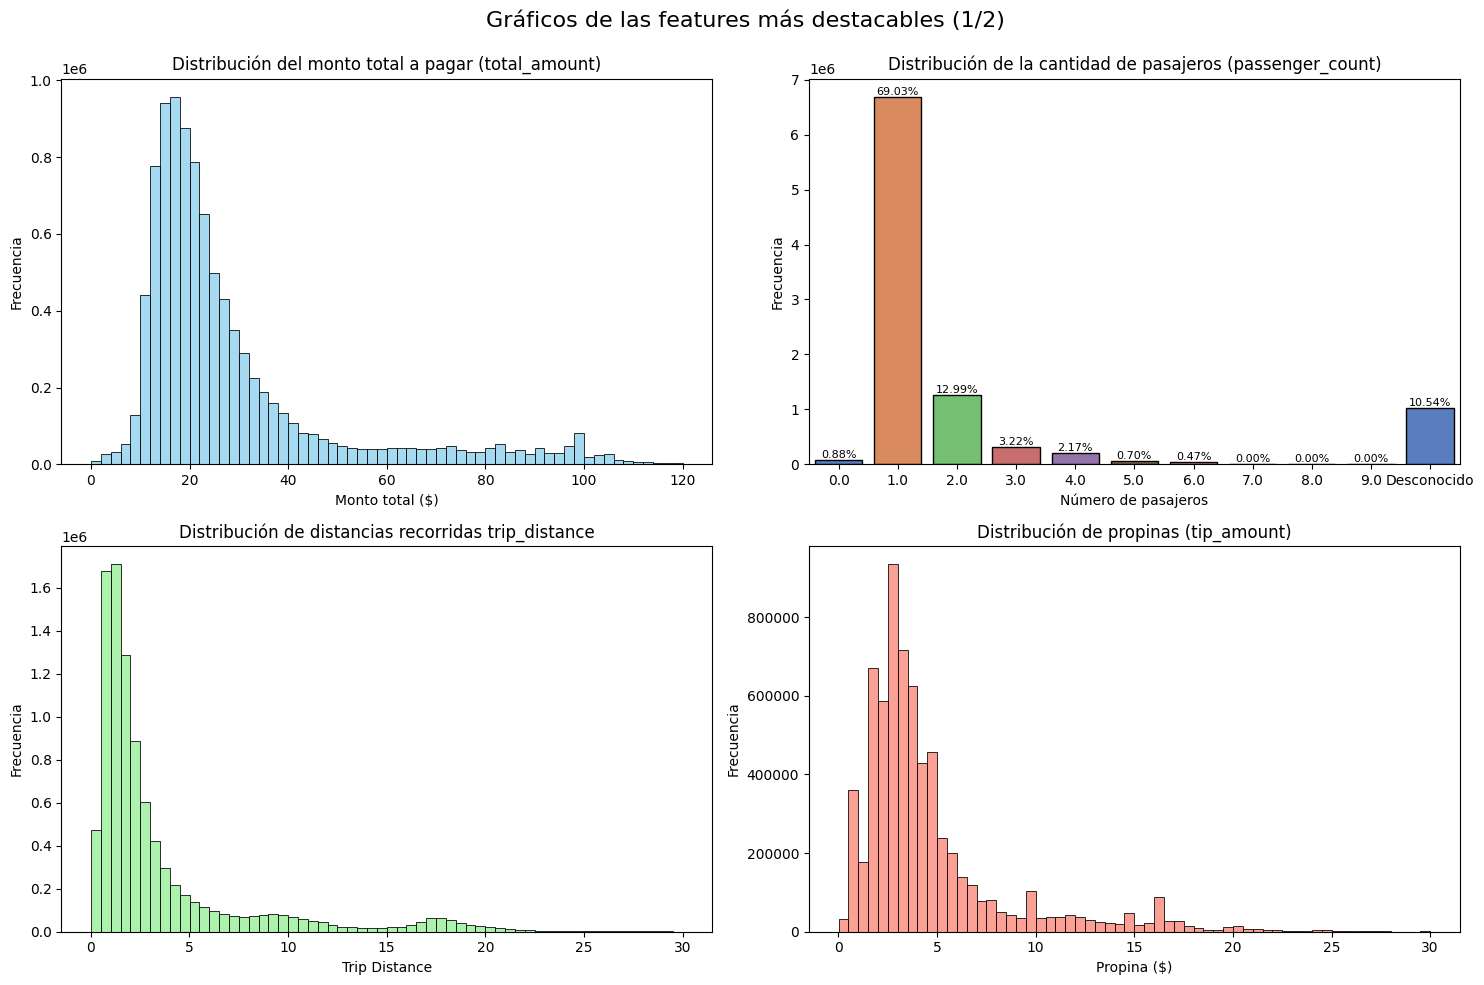

In [10]:
#Ponemos varios gráficos de las variables más importantes
#Creamos una cuadrícula de 2 filas y 2 columnas donde van a ir los gráficos.
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Gráficos de las features más destacables (1/2)", fontsize=16)
#total_amount, passenger_count, trip_distance, tip_amount

# -----------------------------------------------------------------------------------

  #Histograma del total_amount
data_filtrada_amount = data[(data['total_amount'] > 0) & (data['total_amount'] <= 120)] #Filtramos porque sino el gráfico no queda legible

sns.histplot(data=data_filtrada_amount,
            x='total_amount',
            bins=60,
            ax=axs[0, 0], #fila 1, col 1
            color='skyblue',
            edgecolor='black'
            )

#Mostramos título y ejes
axs[0, 0].set_title('Distribución del monto total a pagar (total_amount)')
axs[0, 0].set_xlabel('Monto total ($)')
axs[0, 0].set_ylabel('Frecuencia')

# -----------------------------------------------------------------------------------

  #Barra del passenger_count
data_filtrada_passenger = data['passenger_count'].fillna("Desconocido").astype(str) #Pasamos los nan a Desconocido

tabla_frecuencia = data_filtrada_passenger.value_counts().reset_index()
tabla_frecuencia.columns = ['passenger_count', 'count']

tabla_frecuencia['porcentaje'] = (tabla_frecuencia['count'] / tabla_frecuencia['count'].sum()) * 100 #Calculamos el porcentaje

#Convertimos a número donde se pueda, los demás quedan como NaN (o sea el tema de Desconocido)
tabla_frecuencia['orden'] = pd.to_numeric(tabla_frecuencia['passenger_count'], errors='coerce')
tabla_frecuencia = tabla_frecuencia.sort_values(by=['orden', 'passenger_count'])

sns.barplot(
    data=tabla_frecuencia,
    x='passenger_count',
    y='count',
    palette='muted',
    hue='passenger_count',
    legend=False,
    edgecolor='black',
    ax=axs[0, 1]
)

#Mostramos título y ejes
axs[0, 1].set_title("Distribución de la cantidad de pasajeros (passenger_count)")
axs[0, 1].set_xlabel('Número de pasajeros')
axs[0, 1].set_ylabel('Frecuencia')

#Agregamos porcentajes encima de cada barra
for bar, porcentaje in zip(axs[0, 1].patches, tabla_frecuencia['porcentaje']): #Por cada barra...
    x = bar.get_x() + bar.get_width() / 2 #Para que quede centrado en la barra
    y = bar.get_height() #Para que quede arriba
    axs[0, 1].text(x, y, f"{porcentaje:.2f}%", ha='center', va='bottom', fontsize=8) #Escribe el texto sobre la barrita, basandose en las posiciones x e y de antes

# -----------------------------------------------------------------------------------

  #Histograma del trip_distance
data_filtrada_trip = data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 30)] #Filtramos porque sino el gráfico no queda legible

sns.histplot(
    data=data_filtrada_trip['trip_distance'],
    bins=60,
    ax=axs[1, 0],
    color='lightgreen',
    edgecolor='black'
)

#Mostramos título y ejes
axs[1, 0].set_title('Distribución de distancias recorridas trip_distance')
axs[1, 0].set_xlabel('Trip Distance')
axs[1, 0].set_ylabel('Frecuencia')

# -----------------------------------------------------------------------------------
  #Histograma de propinas
data_filtrada_tip = data[(data['tip_amount'] > 0) & (data['tip_amount'] <= 30)] #Filtramos porque sino el gráfico no queda legible

sns.histplot(
    data=data_filtrada_tip['tip_amount'],
    bins=60,
    ax=axs[1, 1],
    color='salmon',
    edgecolor='black'
)

#Mostramos título y ejes
axs[1, 1].set_title('Distribución de propinas (tip_amount)')
axs[1, 1].set_xlabel('Propina ($)')
axs[1, 1].set_ylabel('Frecuencia')

# -----------------------------------------------------------------------------------

plt.tight_layout(rect=[0, 0, 1, 1]) #Sin esto el 9 y Desconocido se solapan
plt.show()

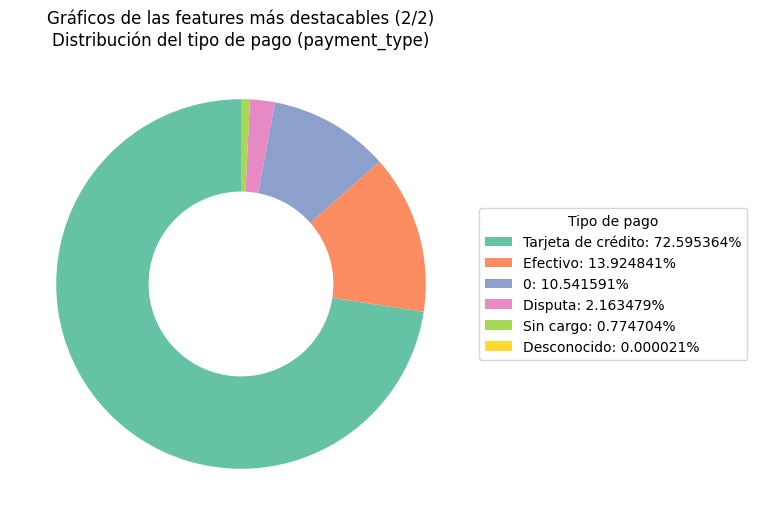

In [11]:
#Gráfico de dona del payment_type
#Calculamos porcentajes (incluyendo nan!!)
porcentajes_payment = data['payment_type'].value_counts(normalize=True, dropna=False) * 100

#Planteamos el diccionario de etiquetas para la leyenda
etiquetas_payment = {
    0: "0",
    1: "Tarjeta de crédito",
    2: "Efectivo",
    3: "Sin cargo",
    4: "Disputa",
    5: "Desconocido",
    6: "Viaje sin propina"
}


enteros_y_nan_payment = [(int(i) if pd.notna(i) else "NaN") for i in porcentajes_payment.index] #Creamos una lista de claves formateadas para el gráfico, haciendo que los
                                                                    #NO nan se pasen a enteros y sino se asegura de que sea nan
valores_porcentajes_payment = list(porcentajes_payment.values) #Se pasan los porcentajes a una lista
nombres_payment = [etiquetas_payment.get(i, str(i)) for i in enteros_y_nan_payment] #Se preparan los nombres para la leyenda!!
colors = sns.color_palette("Set2", len(enteros_y_nan_payment))

#Creamos gráfico de dona
fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(valores_porcentajes_payment, colors=colors, startangle=90, wedgeprops=dict(width=0.5)) #Dona!!

leyenda = [f"{nombre}: {valor:.6f}%" for nombre, valor in zip(nombres_payment, valores_porcentajes_payment)] #6 decimales para que se vean bien los chicos que no aparecen en la dona
ax.legend(wedges, leyenda, title="Tipo de pago", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Gráficos de las features más destacables (2/2)\nDistribución del tipo de pago (payment_type)")
plt.show()

El gráfico de torta va por separado porque es complejo ponerlo en filas y columnas, porque aparentemente la libreria descargada permite gráficos xy

NUEVO LARA: estos dos graficos traidos de lo viejo

**DOLocationID (bajada) + cantidad de pasajeros  -> esta ver donde la ponemos, pq la de abajo es mas completa me parece

In [12]:
data_agrupada_DOL = data.groupby('DOLocationID', as_index=False)['passenger_count'].sum()

# Unimos con 'stations' para obtener las zonas y boroughs
data_DOL_y_stations = data_agrupada_DOL.merge(stations, left_on='DOLocationID', right_on='LocationID')

# Reemplazamos NaN por "Sin datos" para que Plotly no tire error
data_DOL_y_stations['Borough'] = data_DOL_y_stations['Borough'].fillna('Sin datos') #por ahora queda sin datos si hay nan en borough
data_DOL_y_stations['Zone'] = data_DOL_y_stations['Zone'].fillna('Zona desconocida') #y zona desconocida si hay nan en zone

#SI NO HACIA ESE FILTRO DE ARRIBA, ME ROMPIA!!!!!!!!!

# Creamos el treemap
fig = px.treemap(
    data_DOL_y_stations,
    path=['Borough', 'Zone'],
    values='passenger_count',
    title="Zona donde se bajan más pasajeros",
    color='passenger_count',
    color_continuous_scale='YlGnBu'
)

fig.update_coloraxes(colorbar_title="Cantidad de pasajeros")
fig.show()

¿Cuales son las estaciones de Taxi más frecuentadas?

In [13]:
# Unimos todas las locaciones
all_locations = pd.concat([data['PULocationID'], data['DOLocationID']])
location_counts = all_locations.value_counts().reset_index()
location_counts.columns = ['LocationID', 'Count']

# Convertimos location_counts a DataFrame y unimos con `stations` para obtener Borough y Zone
location_info = location_counts.merge(stations, on='LocationID', how='left')

# Reemplazamos los valores faltantes por etiquetas neutrales para evitar errores en el gráfico
location_info['Borough'] = location_info['Borough'].fillna('Sin datos')
location_info['Zone'] = location_info['Zone'].fillna('Zona desconocida')

# Creamos el treemap
fig = px.treemap(
    location_info,
    path=['Borough', 'Zone'],
    values='Count',
    title='Estaciones de Taxi mas frecuentadas en NYC',  #antes se llamaba Tendencia de uso de estaciones de taxi en NYC
    color='Count',
    color_continuous_scale='Inferno' #idealmente deberia ser 'YlGnBu'
)

fig.update_coloraxes(colorbar_title="Cantidad de viajes")
fig.show()

**tpep_pickup_datetime**

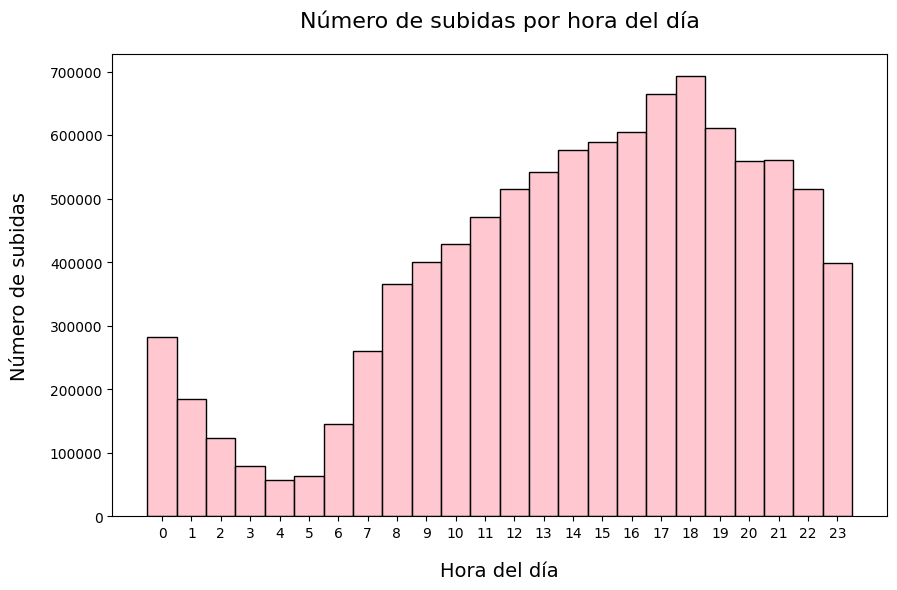

In [14]:
# Asegurar que 'tpep_pickup_datetime' esté en formato datetime
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])

# Crear gráfico de barras (histograma) para las horas del día
plt.figure(figsize=(10, 6))

# Histograma con mejor alineación de barras
sns.histplot(data['tpep_pickup_datetime'].dt.hour, bins=range(25), kde=False, color='lightpink', discrete=True)

# Títulos y etiquetas
plt.title('Número de subidas por hora del día', fontsize=16, pad=20)
plt.xlabel('Hora del día', fontsize=14, labelpad=15)
plt.ylabel('Número de subidas', fontsize=14, labelpad=15)

# Centrar los ticks sobre las barras
plt.xticks(np.arange(24) , labels=np.arange(24))

# Mostrar el gráfico
plt.show()

Podemos observar que la hora donde más se suben pasajeros es a las 18:00 hs

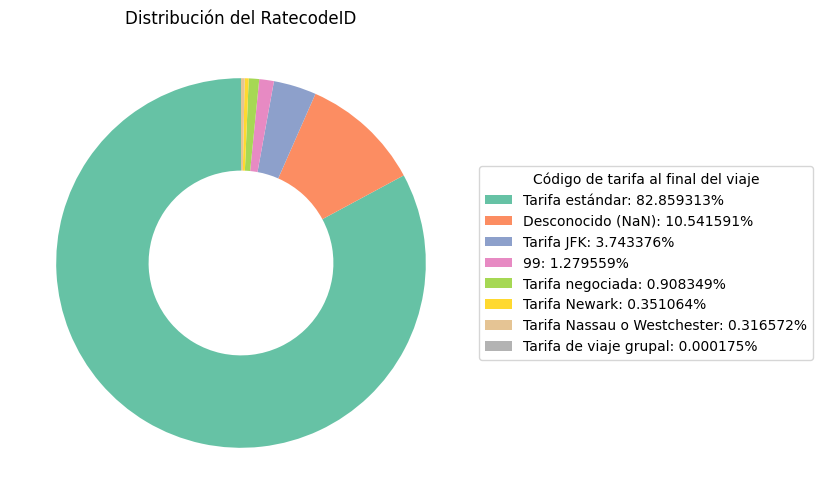

In [15]:
#Gráfico de dona del RatecodeID
#Calculamos porcentajes (incluyendo nan!!)
porcentajes_ratecode = data['RatecodeID'].value_counts(normalize=True, dropna=False) * 100

#Planteamos el diccionario de etiquetas para la leyenda
etiquetas_ratecode = {
    1: "Tarifa estándar",
    2: "Tarifa JFK",
    3: "Tarifa Newark",
    4: "Tarifa Nassau o Westchester",
    5: "Tarifa negociada",
    6: "Tarifa de viaje grupal",
    "NaN": "Desconocido (NaN)"
}

enteros_y_nan_ratecode = [(int(i) if pd.notna(i) else "NaN") for i in porcentajes_ratecode.index] #Creamos una lista de claves formateadas para el gráfico, haciendo que los
                                                                    #NO nan se pasen a enteros y sino se asegura de que sea nan
valores_porcentajes_ratecode = list(porcentajes_ratecode.values) #Se pasan los porcentajes a una lista
nombres_ratecode = [etiquetas_ratecode.get(i, str(i)) for i in enteros_y_nan_ratecode] #Se preparan los nombres para la leyenda!!
colors = sns.color_palette("Set2", len(enteros_y_nan_ratecode))

#Creamos gráfico de dona
fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(valores_porcentajes_ratecode, colors=colors, startangle=90, wedgeprops=dict(width=0.5)) #Dona!!

leyenda = [f"{nombre}: {valor:.6f}%" for nombre, valor in zip(nombres_ratecode, valores_porcentajes_ratecode)] #6 decimales para que se vean bien los chicos que no aparecen en la dona
ax.legend(wedges, leyenda, title="Código de tarifa al final del viaje", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Distribución del RatecodeID")
plt.show()



Se aprecia que el 6 (que es Voided trip, viaje donde se canceló la propina) NO figura en la base de datos. Por eso no aparece en la leyenda del gráfico, ya que al calcular los porcentajes del diccionario ese valor ni existe.


##Correlación de variables
Analizamos las correlaciones existentes entre las variables

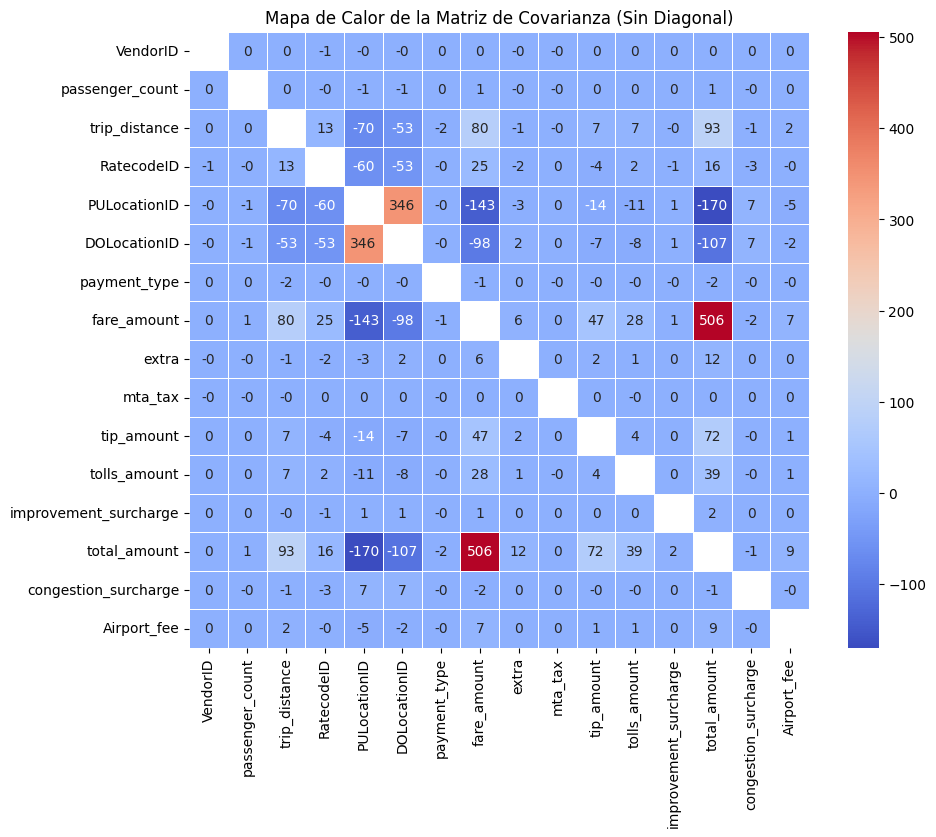

In [16]:
matriz_cov = data.cov(numeric_only=True).round(0)

# Crear una máscara para ocultar solo la diagonal
mask = np.eye(len(matriz_cov), dtype=bool)  # Matriz identidad para ocultar solo la diagonal

# Crear el heatmap con la máscara
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_cov, mask=mask, annot=True, fmt=".0f", cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("Mapa de Calor de la Matriz de Covarianza (Sin Diagonal)")
plt.show()


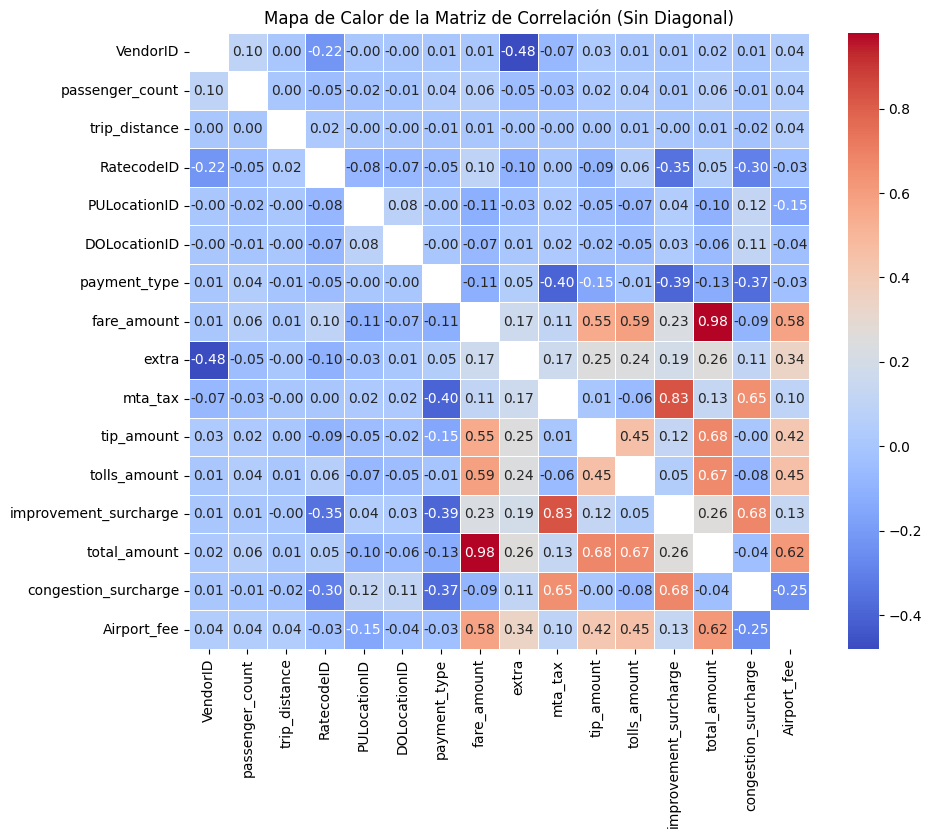

In [17]:
matriz_corr = data.corr(numeric_only=True).round(2)

# Crear una máscara para ocultar solo la diagonal
mask = np.eye(len(matriz_corr), dtype=bool)

# Crear el heatmap con la máscara
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("Mapa de Calor de la Matriz de Correlación (Sin Diagonal)")
plt.show()


Correlaciones entre:

- fare_amount y total_amount: Esta se podria considerar la mas deducible de todas, ya que mientras mas grande sea la tarifa del viaje, tambien mayor sera lo que pagará el pasajero (incluyendo impuestos, propinas, peajes, etc)

- tip_amount y total_amount:Tambien deducible, mientras mas largo y costoso el viaje, mas probable es que el conductor se lleve una mejor propina.

- mta_tax y improvement_surcharge



---
##b) Datos Faltantes

Para realizar un análisis de datos faltantes, primero graficamos para cada variable el porcentaje de datos faltantes con respecto al total del dataset
y luego calculamos el porcentaje de datos faltantes de cada
registro.

In [18]:
#Vemos la cantidad de valores nulos por columna
data.isnull().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,1021387
trip_distance,0
RatecodeID,1021387
store_and_fwd_flag,1021387
PULocationID,0
DOLocationID,0
payment_type,0


Observamos que en cinco columnas: **congestion_surcharge, Airport_fee, passenger_count, ratecodeID, y store_and_fwd_flag**, la cantidad de valores es la **misma**.


Porcentaje de datos faltantes por variable:
+----------------------+----------------------------------------------+
| Variable             | Porcentaje de datos faltantes por variable   |
+======================+==============================================+
| passenger_count      | 10.542%                                      |
+----------------------+----------------------------------------------+
| RatecodeID           | 10.542%                                      |
+----------------------+----------------------------------------------+
| store_and_fwd_flag   | 10.542%                                      |
+----------------------+----------------------------------------------+
| congestion_surcharge | 10.542%                                      |
+----------------------+----------------------------------------------+
| Airport_fee          | 10.542%                                      |
+----------------------+----------------------------------------------+




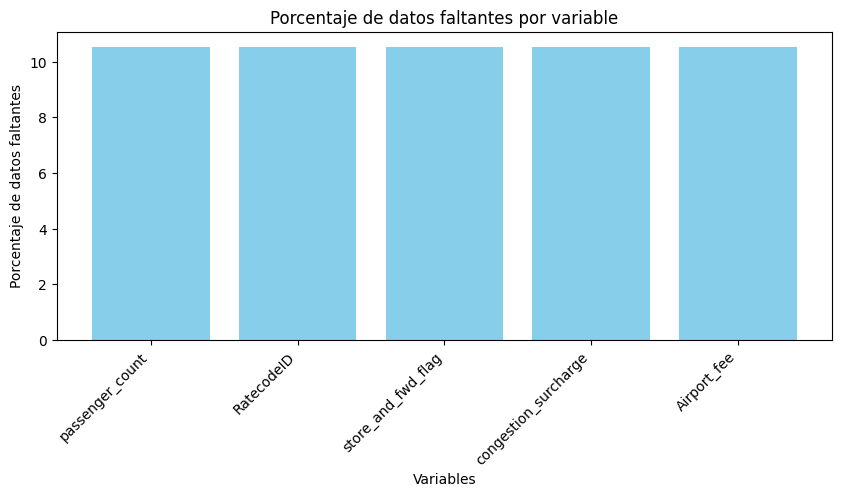

In [19]:
valores_faltantes = data.isnull().sum(axis=0) / data.shape[0] * 100 #sumo la cantidad de nan y lo divido por la cantidad de filas

#print("\nFaltantes por Variable:")
#print(data.isnull().sum(axis=0)) #esto nos dice cuanta ccantidad de datos nul tiene el registro

#print(f"La cantidad total de datos faltantes por columna es:\n{valores_faltantes}")

# muestro solo los q verdaderamente tienen datos faltantes
valores_faltantes = valores_faltantes[valores_faltantes > 0].sort_values(ascending=False) #esto solo lo ordena de manera descendente ALSO: no se pq salta ese warning amarillo XD

tabla_de_faltantes = [[columna, f"{porcentaje:.3f}%"] for columna, porcentaje in valores_faltantes.items()]
print("\nPorcentaje de datos faltantes por variable:")

print(tabulate(tabla_de_faltantes, headers=["Variable", "Porcentaje de datos faltantes por variable"], tablefmt="grid"))


"""for columna, porcentaje in valores_faltantes.items(): #itero
    print(f"{columna}: {porcentaje:.3f}%") #cuantos decimales queremos que tenga? VER

"""
print("\n")
#GRAFICO

plt.figure(figsize=(10, 4))
plt.bar(valores_faltantes.index, valores_faltantes.values, color='skyblue')
plt.xlabel('Variables')
plt.ylabel('Porcentaje de datos faltantes')
plt.title('Porcentaje de datos faltantes por variable')
plt.xticks(rotation=45, ha='right')
plt.show()


Distribución del porcentaje de datos faltantes por fila:

In [20]:
# Calculao cantidad de nulos y porcentaje por fila
cant_nulos_fila = data.isnull().sum(axis=1)
porcentajes_nulos = (cant_nulos_fila / data.shape[1]) * 100

# Filtrao filas con al menos un nulo
porcentajes_nulos = porcentajes_nulos[porcentajes_nulos > 0]

# Agrupo por porcentaje redondeado a 1 decimal
agrupados = porcentajes_nulos.round(1).value_counts().sort_index()

print(f"{'Porcentaje Nulos':>20}  |  {'Cantidad de Registros':>15}")
print("-" * 40)
for porcentaje, cantidad in agrupados.items():
    print(f"{porcentaje:>20.1f}% | {cantidad:>15}")


    Porcentaje Nulos  |  Cantidad de Registros
----------------------------------------
                26.3% |         1021387


Esto quiere decir que hay 1.021.387 registros que contienen un 23,8% de datos nulos

Analizamos si existen filas duplicadas:

In [21]:
print(f'Cantidad de filas duplicadas: {data.duplicated().sum()}')

Cantidad de filas duplicadas: 1


In [22]:
data = data.drop_duplicates() #Eliminamos la fila duplicada
data.reset_index(drop=True, inplace=True) #Reseteamos el indice despues de eliminar filas

Una vez analizados los datos, tenemos que tomar desiciones sobre qué hacer con los datos faltantes

Decidimos empezar con la cantidad de pasajeros.

In [23]:
print(data['passenger_count'].value_counts())

passenger_count
1.000000    6688425
2.000000    1258154
3.000000     312207
4.000000     210271
0.000000      85708
5.000000      67664
6.000000      45240
8.000000         33
7.000000         16
9.000000         10
Name: count, dtype: int64


In [24]:
print(data['passenger_count'].unique())

[ 1.  0.  2.  3.  4.  5.  6.  8.  9.  7. nan]


Podemos ver que los valores de la variable **passenger_count** van del 0 al 9.
 A la cantidad de pasajeros 0 y NaN decidimos eliminarlos ya que no creemos que son valores relevantes para seguir analizando y relacionando con otras variables. Aquellos viajes que tienen más de 4 pasajeros, dado que el máximo estipulado para la cantidad de pasajeros en los taxis de Nueva York es 4, también decidimos eliminarlos ya que no son valores permitidos.


In [25]:
"""
#Hot deck imputacion de datos.       copiar detona el colab XD
data_filtrada = data.copy()
data_filtrada = data_filtrada[(data_filtrada['passenger_count'] != 0) & (data_filtrada['passenger_count'].notna()) & (data_filtrada['passenger_count'] <= 4)]
"""

"\n#Hot deck imputacion de datos.       copiar detona el colab XD\ndata_filtrada = data.copy()\ndata_filtrada = data_filtrada[(data_filtrada['passenger_count'] != 0) & (data_filtrada['passenger_count'].notna()) & (data_filtrada['passenger_count'] <= 4)]\n"

Respecto la variable **store_and_fwd_flag**, creemos que puede estar correlacionada con la distancia de los viajes

In [ ]:
print(data['trip_distance'].describe())
print("\n")

# Veo la distribución con un boxplot --> ver si las distancias son más largas o más variables cuando el viaje fue almacenado (Y) versus enviado directamente (N)
plt.figure(figsize=(8, 5))
sns.boxplot(x='store_and_fwd_flag', y='trip_distance', data=data)
plt.title('Distribución de distancias por store_and_fwd_flag')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('trip_distance')
plt.show()

print("\n")
print("Distribución de distancia en registros con store_and_fwd_flag nulo:")
print(data[data['store_and_fwd_flag'].isnull()]['trip_distance'].describe())

print("\nDistribución de distancia en registros conocidos (Y/N):")
print(data[data['store_and_fwd_flag'].notnull()]['trip_distance'].describe())

print("\n")

# Definir los tramos de distancia y las etiquetas
bins = [0, 1, 5, 10, 20, 50, 100, 330397.59]
labels = ["(0.0, 1.0]", "(1.0, 5.0]", "(5.0, 10.0]", "(10.0, 20.0]", "(20.0, 50.0]", "(50.0, 100.0]", "(100.0, 330397.59]"]

# Calcular el porcentaje de nulos por tramo de distancia
proporcion_nulos = data.groupby(pd.cut(data['trip_distance'], bins=bins, labels=labels))['store_and_fwd_flag'].apply(lambda x: x.isnull().mean() * 100)

# Convertir a un DataFrame para usar tabulate
tabla_nulos = proporcion_nulos.reset_index(name="Porcentaje de Nulos")

# Redondear los valores para mejor presentación
tabla_nulos["Porcentaje de Nulos"] = tabla_nulos["Porcentaje de Nulos"].round(2)

# Imprimir la tabla con formato fancy_grid
print(tabulate(tabla_nulos, headers=["Tramo de Distancia", "Porcentaje de Nulos"], tablefmt="fancy_grid", stralign="center"))

count   9689115.000000
mean          5.296568
std         433.935475
min           0.000000
25%           1.030000
50%           1.800000
75%           3.540000
max      330397.590000
Name: trip_distance, dtype: float64




Este gráfico muestra cómo la probabilidad de que el valor de store_and_fwd_flag sea nulo cambia según la distancia del viaje. Dado que los porcentajes de nulos varían de manera significativa según el tramo de distancia, parece que no existe un patrón claro y constante para poder sustituir los valores nulos. Dado esto, optamos por eliminar los datos nulos

In [ ]:
data = data.drop(columns=['store_and_fwd_flag'])

Vamos a analizar la variable **Airport_fee**

Vemos que hay 1.021.387 valores faltantes.
Nosotros sabemos que la variable aplica el impuesto de 1.25 USD si los viajes comenzaron en los aeropuertos de La Guardia y JFK. Por lo cual, podemos completar los datos teniendo en cuenta el ID correspondiente a cada aeropuerto, es decir, basándonos en si la PULocationID concuerda, si es así se asigna 1.25, caso contrario se asigna 0.

Dadoo esto, realizamos una imputación de datos univariada respecto la variable LocationID


In [ ]:
#Reemplazamos de datos faltantes en airport_fee: si el/los pasajeros se subieron en los aeropuertos de LaGuardia y JFK y es nan, se aplica el 1.25
                                            #SINO --> si es nan y se subieron en otro lado, se aplica 0.
#JFK está en Barrio (Borough) QUEENS, Zone JFK Airport
id_aeropuerto_JFK = stations.loc[(stations['Borough'] == "Queens") & (stations['Zone'] == "JFK Airport"),'LocationID'].values[0]

#LaGuardia está en Barrio (Borough) QUEENS, Zone LaGuardia Airport
id_aeropuerto_LG = stations.loc[(stations['Borough'] == "Queens") & (stations['Zone'] == "LaGuardia Airport"),'LocationID'].values[0]

#-----------------------------------------
  #Vemos si los que tienen 1.25 tienen ID de JFK o LG
cantidad_125_sin_ID = data[(~data['PULocationID'].isin([id_aeropuerto_JFK, id_aeropuerto_LG])) & (data['Airport_fee'] == 1.25)].shape[0]

#-----------------------------------------
  #Reemplazamos los NaN por 1.25 si el pick-up fue en JFK o LaGuardia
#PULocation es cuando se activó el taxímetro --> empieza el viaje
data.loc[data['PULocationID'].isin([id_aeropuerto_JFK, id_aeropuerto_LG]) & data['Airport_fee'].isna(), 'Airport_fee'] = 1.25

#Chequeamos
cantidad_nan_JFK = data[(data['PULocationID'] == id_aeropuerto_JFK) & (data['Airport_fee'].isna())].shape[0]
cantidad_nan_LG = data[(data['PULocationID'] == id_aeropuerto_LG) & (data['Airport_fee'].isna())].shape[0]

#-----------------------------------------
  #Reemplazamos los NaN que NO son de los aeropuertos por 0
nan_fuera_de_aeropuertos = data[~data['PULocationID'].isin([id_aeropuerto_JFK, id_aeropuerto_LG]) & data['Airport_fee'].isna()].shape[0]

data.loc[~data['PULocationID'].isin([id_aeropuerto_JFK, id_aeropuerto_LG]) & data['Airport_fee'].isna(),'Airport_fee'] = 0.0

#Chequeamos
total_nan_restantes = data['Airport_fee'].isna().sum()

Continuamos con la variable **RatecodeID**.

Realizamos una Imputación de datos faltantes multivariada con las variables DOLocationID y PULocationID

In [ ]:
#Reemplazamos los valores restantes de RatecodeID -->
                                                       #JFK --> Ratecode = 2 (Tarifa fija desde/hacia el Aeropuerto JFK)
                                                       #Newark --> Ratecode = 3 (Viaje desde/hacia Newark Airport)
                                                       #Nassau o Westchestern --> Ratecode = 4 (Viajes desde/hacia los condados suburbanos cercanos a NYC: Nassau (Long Island) o Westchester)

#Reemplazamos
data.loc[((data['PULocationID'] == id_aeropuerto_JFK) | (data['DOLocationID'] == id_aeropuerto_JFK)) & (data['RatecodeID'].isna()), 'RatecodeID'] = 2

#Chequeamos
cantidad_ratecode_nan_jfk = data[((data['PULocationID'] == id_aeropuerto_JFK) | (data['DOLocationID'] == id_aeropuerto_JFK)) & (data['RatecodeID'].isna())].shape[0]

#-----------------------------------------

#En Barrio (Borough) está EWR, que es justamente Newark Airport y en Zone está Newark Airport como tal
#Entonces buscamos y nos quedamos con la id de Newark
id_aeropuerto_Newark = stations.loc[(stations['Borough'] == "EWR") & (stations['Zone'] == "Newark Airport"),'LocationID'].values[0]

#Reemplazamos
data.loc[((data['PULocationID'] == id_aeropuerto_Newark) | (data['DOLocationID'] == id_aeropuerto_Newark)) & (data['RatecodeID'].isna()), 'RatecodeID'] = 3

#Chequeamos
cantidad_ratecode_nan_newark = data[((data['PULocationID'] == id_aeropuerto_Newark) | (data['DOLocationID'] == id_aeropuerto_Newark)) & (data['RatecodeID'].isna())].shape[0]

#-----------------------------------------
  #Ratecode = 4 (Nassau o Westchestern)
#Como están fuera de NYC y no hay información al respecto, en Zone hay una que es Outside of NYC
id_outside_NYC = stations.loc[stations['Zone'] == "Outside of NYC", 'LocationID'].values[0]

#Reemplazamos
data.loc[((data['PULocationID'] == id_outside_NYC) | (data['DOLocationID'] == id_outside_NYC)) & (data['RatecodeID'].isna()), 'RatecodeID'] = 4

#Chequeamos
cantidad_ratecode_nan_outside_NYC = data[((data['PULocationID'] == id_outside_NYC) | (data['DOLocationID'] == id_outside_NYC)) & (data['RatecodeID'].isna())].shape[0]

Seguimos con la variable **congestion_surcharge**.

En este caso analizamos dónde se aplica el impuesto, que es debajo (al sur) de la 96th Street. Sabiendo eso, vimos qué zonas del dataframe pertenecían a ese grupo donde el impuesto era aplicable.

In [ ]:
#Vemos el congestion_surcharge
cantidad_nan_congestion = data[(data['congestion_surcharge'].isna())].shape[0]

#Es un recargo obligatorio por congestión vehicular que se aplica en Manhattan al sur de la calle 96th Street, implementado a partir de enero de 2019.
#busca reducir el tráfico en el centro de Manhattan y financiar mejoras en el transporte público.
#El Barrio va a ser Manhattan

#El monto del recargo depende del tipo de vehículo que se utilice para el transporte en o a través de la zona de congestionamiento. El recargo generalmente es:
    #$2.50 por cada viaje cuando el transporte sea en taxi amarillo.
    #$0.75 por cada viaje compartido. (NO ES QUE SEA MAS DE UNA PERSONA, ES QUE NO SE CONOZCAN Y TENGAN DESTINO DISTINTO(?))
      #RatecodeID = 6 es viaje compartido

zonas_sur_manhattan = [
    'Alphabet City', 'Battery Park', 'Battery Park City', 'Chinatown', 'Clinton East', 'Clinton West', 'East Chelsea', 'East Village',
    'Financial District North', 'Financial District South', 'Flatiron', 'Garment District',"Governor's Island/Ellis Island/Liberty Island",
    'Gramercy', 'Greenwich Village North', 'Greenwich Village South', 'Hudson Sq', 'Kips Bay', 'Lenox Hill East', 'Lenox Hill West', 'Lincoln Square East',
    'Lincoln Square West', 'Little Italy/NoLiTa', 'Lower East Side', 'Meatpacking/West Village West', 'Midtown Center', 'Midtown East',
    'Midtown North', 'Midtown South', 'Murray Hill', 'Penn Station/Madison Sq West',
    'Seaport', 'SoHo', 'Stuy Town/Peter Cooper Village', 'Sutton Place/Turtle Bay North', 'Times Sq/Theatre District',
    'TriBeCa/Civic Center', 'Two Bridges/Seward Park', 'UN/Turtle Bay South', 'Union Sq', 'Upper East Side South', 'Upper West Side South',
    'West Chelsea/Hudson Yards', 'West Village', 'World Trade Center']
location_ids_sur_manhattan = stations[stations['Zone'].isin(zonas_sur_manhattan)]['LocationID'].tolist()


#Chequeamos
cantidad_viaje_en_grupo_congestion = data[(data['RatecodeID'] == 6) & (data['congestion_surcharge'].isna()) &
                                    (data['PULocationID'].isin(location_ids_sur_manhattan) | data['DOLocationID'].isin(location_ids_sur_manhattan))].shape[0]

#Reemplazamos por 2.5
data.loc[(data['congestion_surcharge'].isna()) & (data['RatecodeID'] != 6) &
        (data['PULocationID'].isin(location_ids_sur_manhattan) | data['DOLocationID'].isin(location_ids_sur_manhattan)),
        'congestion_surcharge'] = 2.50

#Chequeamos
cantidad_viaje_normales_congestion = data[(data['congestion_surcharge'].isna()) &
                                    (data['PULocationID'].isin(location_ids_sur_manhattan) | data['DOLocationID'].isin(location_ids_sur_manhattan))].shape[0]


#Reemplazamos por 0 si NO subieron/bajaron en el sur de Manhattan (los NaN que quedan)
data.loc[(data['congestion_surcharge'].isna()),'congestion_surcharge'] = 0.0

<img src="https://i.redd.it/k41lk93nxbjc1.jpeg" width="500"/>

## c) Valores Atípicos

*   Detectar valores atípicos en los datos tanto en forma univariada como multivariada
*   Realizar gráficos que permitan visualizar los valores atípicos.
*   Explicar qué características poseen los datos atípicos detectados y decidir el tratamiento a aplicar sobre los mismos.


In [ ]:
variables_numericas = [
    'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
    'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
    'congestion_surcharge', 'Airport_fee', 'VendorID', 'RatecodeID',
    'PULocationID', 'DOLocationID', 'payment_type'
]

# Definir cantidad de columnas
columnas = 3
filas = (len(variables_numericas) + columnas - 1) // columnas

# Crear figura y ejes
fig, axes = plt.subplots(filas, columnas, figsize=(18, filas * 4))
axes = axes.flatten()

# Generar un boxplot para cada variable
for i, col in enumerate(variables_numericas):
    sns.boxplot(data=data, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos (si sobran)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Ajustar diseño
plt.tight_layout()
plt.show()

Vemos que hay muchos valores que no tienen sentido como por ejemplo, tarifas o impuestos negativos, cantidad de pasajeros mayor a 4 personas, distancias de mas de 100 millas


In [ ]:
# Filtrar valores negativos impuestos
data = data[(data["mta_tax"] >= 0) &
            (data["tip_amount"] >= 0) &
            (data["tolls_amount"] >= 0) &
            (data["improvement_surcharge"] >= 0) &
            (data["congestion_surcharge"] >= 0) &
            (data["Airport_fee"] >= 0) &
            (data["extra"] >= 0)]

# Filtrar solo los viajes con "total_amount" mayor que 0
data = data[data["total_amount"] > 0]

# Filtrar viajes con distancias 0 o negativas
data = data[data["trip_distance"] > 0]  # Eliminar distancias <= 0
# Filtrar distancias mayores a 250 millas (DATO: la  vuelta al mundo son 25.000 millas) --< filtramos pues encontramos un viaje de más de 63.000 millas
data = data[data["trip_distance"] < 250]

valores_posibles_ratecodeID = [1, 2, 3, 4, 5, 6]
data = data[data['RatecodeID'].isin(valores_posibles_ratecodeID)]

# Filtrar las filas que sean de 2024 y de los meses 07, 08 y 09
data = data[(data['tpep_pickup_datetime'].dt.year == 2024) &
                     (data['tpep_pickup_datetime'].dt.month.isin([7, 8, 9])) & (data['tpep_dropoff_datetime'].dt.year == 2024) &
                     (data['tpep_dropoff_datetime'].dt.month.isin([7, 8, 9]))]


In [ ]:
variables_numericas = [
    'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
    'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
    'congestion_surcharge', 'Airport_fee', 'VendorID', 'RatecodeID',
    'PULocationID', 'DOLocationID', 'payment_type'
]

# Definir cantidad de columnas
columnas = 3
filas = (len(variables_numericas) + columnas - 1) // columnas

# Crear figura y ejes
fig, axes = plt.subplots(filas, columnas, figsize=(18, filas * 4))
axes = axes.flatten()

# Generar un boxplot para cada variable
for i, col in enumerate(variables_numericas):
    sns.boxplot(data=data, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos (si sobran)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Ajustar diseño
plt.tight_layout()
plt.show()

---
##d) Nuevos Features:

- Analizar qué nuevas variables se pueden crear ya sea que resulten
derivadas de los atributos existentes o de incorporar nuevas fuentes de datos.

Decidimos, de los datos ya existen crear los siguientes features
  
  - trip_duration:
  - month:
  - day_of_the_week: nos permite agrupar los viajes, en los distintos dias
  - bins_trip_distance:
  - rush_hour:
  - z-score (de trip score )
  



In [ ]:

"""
# Calcular la duración del viaje en minutos
data_filtrada["trip_duration"] = (data_filtrada["tpep_dropoff_datetime"] - data_filtrada["tpep_pickup_datetime"]).dt.total_seconds() / 60

# Extraer el mes de la fecha de recogida
data_filtrada["month"] = data_filtrada["tpep_pickup_datetime"].dt.strftime("%B")  # "July", "August", "September"

data_filtrada["weekday_num"] = data_filtrada["tpep_pickup_datetime"].dt.weekday

bins = [0, 5, 10, np.inf]
labels = ['0-5mi', '5-10mi', '10+mi']

data_filtrada['trip_distance_bin'] = pd.cut(data_filtrada['trip_distance'], bins=bins, labels=labels, include_lowest=True)

data_filtrada["z_score_trip_distance"] = z_mod_calculation(data_filtrada.trip_distance)
"""

---
##e) Preguntas de investigacion: reporte

---
##f) Visualización de los datos:

En esta sección se espera que puedan apoyarse en
visualizaciones, combinando distintas variables del dataset que los ayuden a responder preguntas sobre los datos.



NUEVO LARA: sinceramente algun q otro grafico, pero no se pq no andan xd

<ipython-input-35-cf34e5875804>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-cf34e5875804>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-cf34e5875804>:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



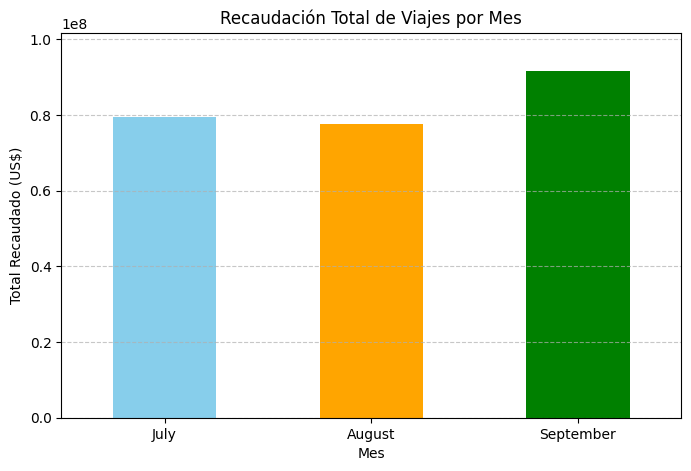

In [35]:
# Extraer el mes
data["mes"] = data["tpep_pickup_datetime"].dt.strftime("%B")  # Nombres de meses

# Definir el orden correcto (solo los que te interesan)
orden_meses = ["July", "August", "September"]
data["mes"] = pd.Categorical(data["mes"], categories=orden_meses, ordered=True)

# Agrupar y sumar
recaudacion_mensual = data.groupby("mes")["total_amount"].sum()

# Crear gráfico
plt.figure(figsize=(8, 5))
recaudacion_mensual.plot(kind="bar", color=["skyblue", "orange", "green"])

plt.xlabel("Mes")
plt.ylabel("Total Recaudado (US$)")
plt.title("Recaudación Total de Viajes por Mes")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, recaudacion_mensual.max() + 10_000_000)

plt.show()

de el de abajo: ver si sacamos 7,8,9

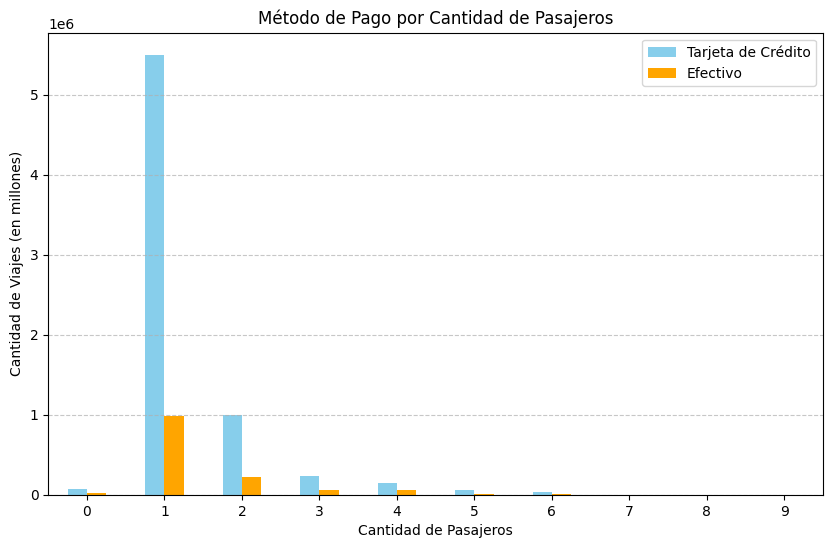

In [33]:
# Filtrar solo los tipos de pago que nos interesan: tarjeta de crédito (1) y efectivo (2)
data = data[data['payment_type'].isin([1, 2])]

# Agrupar por la cantidad de pasajeros y el tipo de pago, luego contar los viajes
viajes_por_pago = data.groupby(['passenger_count', 'payment_type']).size().unstack(fill_value=0)

# Convertir el índice (cantidad de pasajeros) a enteros
viajes_por_pago.index = viajes_por_pago.index.astype(int)

# Crear un gráfico de barras agrupadas
ax = viajes_por_pago.plot(kind='bar', stacked=False, figsize=(10, 6), color=['skyblue', 'orange'])

# Personalizar el gráfico
plt.xlabel("Cantidad de Pasajeros")
plt.ylabel("Cantidad de Viajes (en millones)")
plt.title("Método de Pago por Cantidad de Pasajeros")
plt.xticks(rotation=0)
plt.legend(["Tarjeta de Crédito", "Efectivo"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

In [31]:

# Asegurate de que la columna de fecha sea datetime (solo si aún no lo hiciste)
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])

# Extraer la hora
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour

# Filtrar solo viajes a las 18:00
hora_pico = data[data['pickup_hour'] == 18]

# Contar cantidad de viajes por LocationID de origen
location_counts = hora_pico['PULocationID'].value_counts().reset_index()
location_counts.columns = ['LocationID', 'Count']

# Asegurate de que 'stations' tiene columnas: LocationID, Borough, Zone
# Unir con 'stations' para obtener nombres
location_counts = location_counts.merge(stations, on='LocationID', how='left')

# Reemplazar NaN para evitar errores en Plotly
location_counts['Borough'] = location_counts['Borough'].fillna('Sin datos')
location_counts['Zone'] = location_counts['Zone'].fillna('Zona desconocida')

# Crear gráfico tipo treemap
fig = px.treemap(
    location_counts,
    path=['Borough', 'Zone', 'LocationID'],  # Jerarquía: Borough > Zone > ID
    values='Count',
    title="Zonas con más recogidas en hora pico (18:00)",
    color='Count',
    color_continuous_scale='YlOrRd'
)

fig.update_coloraxes(colorbar_title="Cantidad de Recogidas")

fig.show()

Precio total y medio de pago -> relación

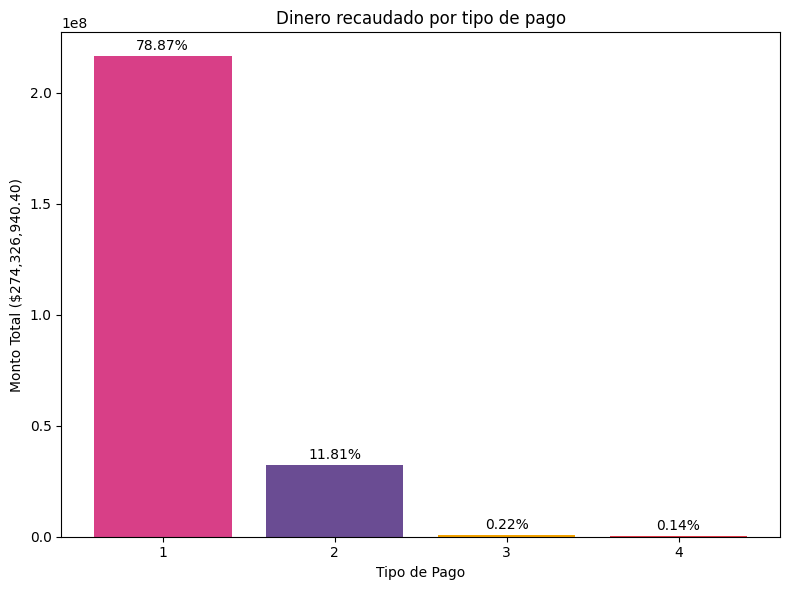

1: Tarjeta de crédito, 2: Efectivo, 3: Sin cargo, 4: Disputa


In [24]:
# AAAAARRREEEEGLAAAAAAAAAAAAAAAAAAAR EL EJE Y Y PONER LOS NOMBRES DE LOS METODOS EN EL EJE X !!!!!!
# Relación entre tipos de pago y monto total recaudado
# Agrupar los datos por tipo de pago y calcular el monto total
data_agrupada_tipos_pago = data.groupby('payment_type')['total_amount'].sum().reset_index()
monto_total = data['total_amount'].sum()

# Filtrar tipos de pago entre 1 y 4
data_agrupada_tipos_pago = data_agrupada_tipos_pago[(data_agrupada_tipos_pago['payment_type'] > 0) &
                                                     (data_agrupada_tipos_pago['payment_type'] < 5)]

# Crear una nueva columna con el porcentaje
data_agrupada_tipos_pago['porcentaje'] = (data_agrupada_tipos_pago['total_amount'] / monto_total) * 100

# Convertir payment_type a str
data_agrupada_tipos_pago['payment_type'] = data_agrupada_tipos_pago['payment_type'].astype(str)

# Establecer los colores de las barras
colores_barras_pagos = {
    '1': '#D83F87',
    '2': '#6A4C93',
    '3': '#F4A300',
    '4': '#E63946'
}

# Datos para el gráfico
x = data_agrupada_tipos_pago['payment_type']
y = data_agrupada_tipos_pago['total_amount']
porcentajes = data_agrupada_tipos_pago['porcentaje']
colores = [colores_barras_pagos[pt] for pt in x]

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x, y, color=colores)

# Agregar los porcentajes arriba de cada barra
for bar, porcentaje in zip(bars, porcentajes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + monto_total * 0.01, f'{porcentaje:.2f}%', ha='center')

# Títulos y etiquetas
ax.set_title("Dinero recaudado por tipo de pago")
ax.set_xlabel("Tipo de Pago")
ax.set_ylabel(f"Monto Total (${monto_total:,.2f})")

plt.tight_layout()
plt.show()

print("1: Tarjeta de crédito, 2: Efectivo, 3: Sin cargo, 4: Disputa")